In [33]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import sys
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score,mean_squared_error
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.tree import DecisionTreeClassifier
from imblearn.under_sampling import RandomUnderSampler
from sklearn.neighbors import KNeighborsClassifier
import category_encoders as ce
import seaborn as sns
import sklearn.metrics as metrics
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

In [ ]:
#install if you don't have these packages
#%pip install xgboost
#%pip install category_encoders
#%pip install imbalanced-learn

#### Here we add a frequency column for each unique user and getting rid of the duplicates in the data

In [3]:
testing_df=pd.read_pickle("./testing.pkl")
testing_df.drop('Unnamed: 0',axis=1,inplace=True)
frequency_df=pd.DataFrame(testing_df.groupby(['userID']).size()).reset_index()
frequency_df.rename(columns={0:'frequency'},inplace=True)
testing_new_df=testing_df.merge(frequency_df,how='left',left_on='userID',right_on='userID')
testing_new_df.drop_duplicates(subset=['userID'],keep='last').head()


,userID,asin,rating,timestamp,y,title,brand,price,main_cat_All Electronics,main_cat_Amazon Devices,...,main_cat_Portable Audio & Accessories,main_cat_Software,main_cat_Sports & Outdoors,main_cat_Tools & Home Improvement,main_cat_Toys & Games,main_cat_Video Games,bought_with,viewed_with,similar_to,frequency
0,A3JSAGWSLY5044,0594017580,3.0,1404432000,0.0,Jonathan Adler Punctuation Cover in Black,Barnes &amp; Nobles,8.99,0,0,...,1,0,0,0,0,0,1,5,0,1
1,A3B12X05JZKM94,0594033896,5.0,1405382400,1.0,Nook Color Clear Screen Protector Kit 2-Pack,Barnes &amp; Noble,1.96,0,0,...,1,0,0,0,0,0,0,0,0,1
2,AKZOMZCNU41GZ,0594033896,4.0,1388620800,0.0,Nook Color Clear Screen Protector Kit 2-Pack,Barnes &amp; Noble,1.96,0,0,...,1,0,0,0,0,0,0,0,0,1
5,AOK77THMKCGXZ,0594033896,4.0,1394496000,0.0,Nook Color Clear Screen Protector Kit 2-Pack,Barnes &amp; Noble,1.96,0,0,...,1,0,0,0,0,0,0,0,0,1
7,A1RTWWRHVIVWQW,0594451647,5.0,1404691200,1.0,Barnes & Noble HDTV Adapter Kit for NOOK HD an...,Barnes &amp; Noble,1.46,0,0,...,0,0,0,0,0,0,0,2,0,1


In [4]:
testing_new_df.reset_index(inplace=True)
X=testing_new_df.drop(columns=['title','userID','asin','rating','timestamp','y','index'])
y=testing_new_df['y'].astype(int)

#### Encoding and getting ready for testing

In [56]:

encoder=ce.woe.WOEEncoder(cols=['brand'])
undersample = RandomUnderSampler(sampling_strategy='majority')
X_train_encoded=encoder.fit_transform(X,y)
X_train, X_test, y_train, y_test = train_test_split(X_train_encoded,y,test_size=0.2, random_state=42)



#### Preliminary round of test to pick two top models

In [ ]:
cv_results={}
result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

models={ 'xgboost':XGBClassifier(),
        'logreg':LogisticRegression(),
        'knn':KNeighborsClassifier(),
        'decisiontree':DecisionTreeClassifier(),
         'NB':GaussianNB(),
         'rf':RandomForestClassifier() }
for model in models.items():
    for train_ind,val_ind in kf.split(X_train,y_train):
        X_tr,y_tr=X_train.iloc[train_ind],y_train.iloc[train_ind]
        X_under_train, y_under_train = undersample.fit_resample(X_tr, y_tr)
        X_val,y_val=X_train.iloc[val_ind],y_train.iloc[val_ind]
        model[1].fit(X_under_train,y_under_train)
        y_pred=model[1].predict(X_val)
        
        precision=precision_score(y_val,y_pred)
        recall=recall_score(y_val,y_pred)
        accuracy=accuracy_score(y_val,y_pred)
        roc_auc=roc_auc_score(y_val,y_pred)
        cv_results[model[0]]=(precision,recall,accuracy,roc_auc,f1)
        
        
   
    yprobs = model[1].predict_proba(X_test)[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, yprobs)
    auc=roc_auc_score(y_test, yprobs)
    result_table=result_table.append({'classifiers':model[0],
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)
        


In [111]:
cv_results

{'xgboost': (0.6945237340099376,
  0.5983069448049435,
  0.6088594199986606,
  0.6111231220458682),
 'logreg': (0.6766076569483546,
  0.5811259409024467,
  0.5901627486437613,
  0.592101311853691),
 'knn': (0.6658520482594853,
  0.5694776483017081,
  0.578586832764048,
  0.5805409221257616),
 'decisiontree': (0.6963448168656229,
  0.5915584031183545,
  0.6079458844015806,
  0.6114613036987993),
 'NB': (0.6782602621418411,
  0.4863640296352964,
  0.5620896122161945,
  0.5783341570426469),
 'rf': (0.692617606910743,
  0.6192219596271453,
  0.6143084857008908,
  0.6132544542266082)}

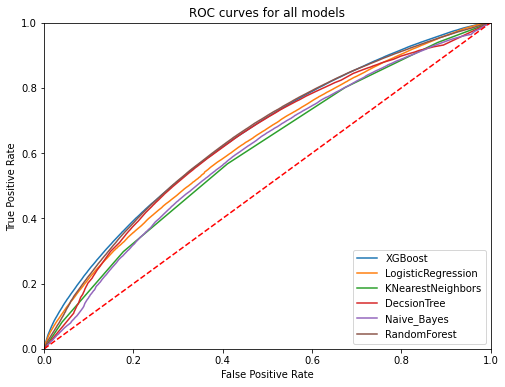

In [118]:
#Plotting the result of the preliminary round on a graph

fig = plt.figure(figsize=(8,6))
modelslist=['XGBoost','LogisticRegression','KNearestNeighbors','DecsionTree','Naive_Bayes','RandomForest']
for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}".format(modelslist[i]))
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC curves for all models')
plt.show()

fig.savefig('ROC_AUC_curve.png')

#### Two models standout: randomforest and XGBoost, now a gridsearch will be conducted

In [ ]:
#Grid search for XGBoost, highly don't recommend running the whole thing with GridSearchCV, try using 
#RandomSearchCV first to narrow down the field then use GridSearch.Same goes for randomforest gridsearch later.

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

encoder = ce.woe.WOEEncoder(cols=['brand'])
X_train_encoded=encoder.fit_transform(X,y)
X_train, X_test, y_train, y_test = train_test_split(X_train_encoded,y,test_size=0.2, random_state=42)

kf=StratifiedKFold(n_splits=5,shuffle=True,random_state=42)


estimator=XGBClassifier(objective='binary:logistic',n_estimators=100,seed=42,learning_rate =0.1,
                        gamma=0.4,min_child_weight=6,reg_alpha=1,subsample=1,colsample_bytree=1,
                        scale_pos_weight=0.7,max_depth=15)



params = {

'max_depth':[4,6,8,10,12,14,16]
'min_child_weight':[4,6,8]
'gamma':[i/10.0 for i in range(0,5)]
'subsample':[i/10.0 for i in range(6,10)],
'colsample_bytree':[i/10.0 for i in range(6,10)]
'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05,0.1,1,100]

}


grid = GridSearchCV(estimator, param_grid=params , cv=kf, scoring='roc_auc',verbose=10,n_jobs=8)
grid.fit(X_train, y_train)
grid.cv_results_, grid.best_params_, grid.best_score_

In [5]:
#Evaluating the XGBoost model with cross validation
encoder = ce.woe.WOEEncoder(cols=['brand'])
X_train_encoded=encoder.fit_transform(X,y)
X_train, X_test, y_train, y_test = train_test_split(X_train_encoded,y,test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_encoded,y,test_size=0.25, random_state=42)
kfold = KFold(n_splits=5, shuffle=True)


model = XGBClassifier(objective='binary:logistic',n_estimators=5000,seed=42,learning_rate =0.01,
                        gamma=0.4,min_child_weight=6,reg_alpha=1,subsample=1,colsample_bytree=1,
                        scale_pos_weight=0.7,max_depth=15)
eval_set = [(X_val, y_val)]
model.fit(X_train, y_train, early_stopping_rounds=10, eval_metric=["error", 'rmse','auc'], eval_set=eval_set, verbose=False)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.4, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=15,
              min_child_weight=6, missing=nan, monotone_constraints='()',
              n_estimators=5000, n_jobs=0, num_parallel_tree=1, random_state=42,
              reg_alpha=1, reg_lambda=1, scale_pos_weight=0.7, seed=42,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [6]:
y_pred = model.predict(X_test)
accuracy_score(y_test, y_pred)
recall_score(y_test,y_pred)

In [73]:
feature_important = model.get_booster().get_score(importance_type='cover')
keys = list(feature_important.keys())
values = list(feature_important.values())
norm = [float(i)/sum(values) for i in values]
data = pd.DataFrame(data=norm, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)[:8]


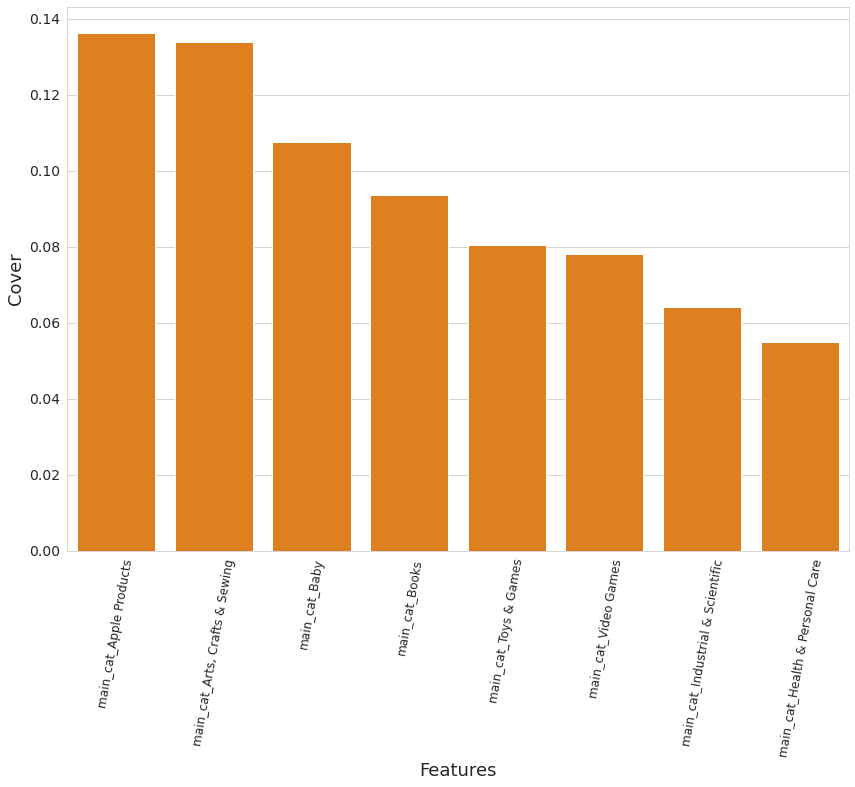

In [75]:
from matplotlib.pyplot import figure
with sns.axes_style('whitegrid'):
    fig, ax = plt.subplots(figsize=(14,10))
    ax=sns.barplot(x=data.index, y='score', data=data,color="#FF8000")
    plt.xlabel('Features', fontsize=18)
    plt.ylabel('Cover', fontsize=18)
    plt.xticks(rotation=80,fontsize=12)
    plt.yticks(fontsize=14)
    plt.savefig('feature_importance.png')


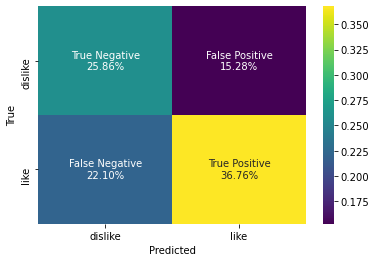

In [106]:
from sklearn.metrics import classification_report,confusion_matrix
cf_matrix=confusion_matrix(y_test, y_pred,normalize='all')
fig=plt.figure()
group_names = ['True Negative','False Positive','False Negative','True Positive']
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v3}' for v1, v3 in
          zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
                     
ax=sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=labels, 
            fmt='', cmap='viridis')

ax.set_xlabel('Predicted')
ax.set_ylabel('True')
labels=['dislike','like']
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)


fig.savefig('confusion_matrix.png')

In [32]:
#Gridsearch for randomforest

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

encoder = ce.woe.WOEEncoder(cols=['brand'])
X_train_encoded=encoder.fit_transform(X,y)
X_train, X_test, y_train, y_test = train_test_split(X_train_encoded,y,test_size=0.2, random_state=42)

kf2=KFold(n_splits=5,shuffle=True,random_state=42)


estimator2=RandomForestClassifier(class_weight={0:1.4,1:1},n_estimators=150,max_leaf_nodes=25,
                                  min_samples_leaf=25,min_samples_split=80,max_depth=20)



params2 = {

'max_features' : [6,8,10,12,14,16,18,20]
'min_samples_leaf' : [10,15,25,40]
'min_samples_split':[40,50,60,70,80,90]
'max_depth' : [6,8,10,12,14,16,20,22,24]



}


grid2 = RandomizedSearchCV(estimator2, param_distributions=params2 , cv=kf2, scoring='roc_auc',verbose=10,n_jobs=8,n_iter = 25)
grid2.fit(X_train, y_train)
grid2.cv_results_, grid2.best_params_, grid2.best_score_

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:282: UserWarning: The total space of parameters 3 is smaller than n_iter=25. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Fitting 4 folds for each of 3 candidates, totalling 12 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:  6.9min
[Parallel(n_jobs=8)]: Done   3 out of  12 | elapsed:  8.0min remaining: 24.1min
[Parallel(n_jobs=8)]: Done   5 out of  12 | elapsed:  8.4min remaining: 11.8min
[Parallel(n_jobs=8)]: Done   7 out of  12 | elapsed:  8.6min remaining:  6.1min
[Parallel(n_jobs=8)]: Done  12 out of  12 | elapsed: 18.2min finished


({'mean_fit_time': array([452.5687834 , 511.88563806, 578.75228733]),
  'std_fit_time': array([29.01206261, 12.39764864, 13.95164348]),
  'mean_score_time': array([4.93344796, 4.94974405, 4.9448905 ]),
  'std_score_time': array([0.00999898, 0.02720682, 0.03877576]),
  'param_max_features': masked_array(data=[16, 18, 20],
               mask=[False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'max_features': 16}, {'max_features': 18}, {'max_features': 20}],
  'split0_test_score': array([0.63602201, 0.6359437 , 0.63573258]),
  'split1_test_score': array([0.63436751, 0.6341946 , 0.63400663]),
  'split2_test_score': array([0.63587905, 0.63558156, 0.6355675 ]),
  'split3_test_score': array([0.63636685, 0.63625148, 0.63607015]),
  'mean_test_score': array([0.63565886, 0.63549284, 0.63534421]),
  'std_test_score': array([0.00076635, 0.00078615, 0.00079322]),
  'rank_test_score': array([1, 2, 3], dtype=int32)},
 {'max_features': 16},
 0.6356588554436252)

In [42]:
#Evaluating RandomForest with tuned hyperparameters
X_train_encoded=encoder.fit_transform(X,y)
X_train, X_test, y_train, y_test = train_test_split(X_train_encoded,y,test_size=0.3, random_state=42)

kfold = KFold(n_splits=5, shuffle=True)


model2 = RandomForestClassifier(class_weight={0: 1.4, 1: 1}, max_depth=20,
                       max_features=16, max_leaf_nodes=25, min_samples_leaf=25,
                       min_samples_split=80, n_estimators=1000,oob_score=True)
eval_set = [(X_val, y_val)]
model2.fit(X_train, y_train)



/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


RandomForestClassifier(class_weight={0: 1.4, 1: 1}, max_depth=20,
                       max_features=16, max_leaf_nodes=25, min_samples_leaf=25,
                       min_samples_split=80, n_estimators=1000, oob_score=True)

In [59]:
y_pred2 = model2.predict(X_test)
accuracy_score(y_test, y_pred)

In [43]:
model2.score(X_test,y_test)

0.5954355749681022

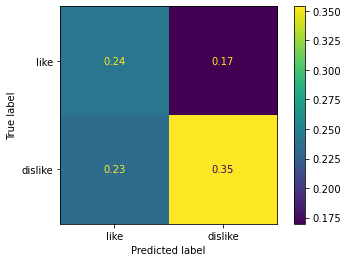

In [64]:
plot_confusion_matrix(model2,X_test,y_test,normalize='all',display_labels=['like','dislike'])